# Forex Prediction Model
This notebook demonstrates the process of training a GRU-TFT model for predicting forex prices using historical data.

## Setup:
Import necessary libraries and set up environment.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


## Data loading and Preprocessing
Clean & load data and perform necessary steps preprocessing steps (eg. indicators as feature engineering).

In [2]:
def compute_technical_indicators(data, indicators):
    for indicator, windows in indicators.items():
        if indicator == 'SMA':
            for window in windows:
                data[f'SMA_{window}'] = data['Close'].rolling(window=window).mean()
        elif indicator == 'EMA':
            for window in windows:
                data[f'EMA_{window}'] = data['Close'].ewm(span=window, adjust=False).mean()
        elif indicator == 'RSI':
            for window in windows:
                data[f'RSI_{window}'] = compute_rsi(data['Close'], window)
        elif indicator == 'Momentum':
            for window in windows:
                data[f'Momentum_{window}'] = data['Close'].diff(window)
        elif indicator == 'Volatility':
            for window in windows:
                data[f'Volatility_{window}'] = data['Close'].rolling(window=window).std()
        elif indicator == 'ROC':
            for window in windows:
                data[f'ROC_{window}'] = data['Close'].pct_change(periods=window)
        elif indicator == 'BB':
            for window in windows:
                data[f'BB_Middle_{window}'] = data['Close'].rolling(window=window).mean()
                data[f'BB_Upper_{window}'] = data[f'BB_Middle_{window}'] + 2 * data['Close'].rolling(window=window).std()
                data[f'BB_Lower_{window}'] = data[f'BB_Middle_{window}'] - 2 * data['Close'].rolling(window=window).std()
        elif indicator == 'MACD':
            for short_window, long_window, signal_window in windows:
                data[f'EMA_Short_{short_window}'] = data['Close'].ewm(span=short_window, adjust=False).mean()
                data[f'EMA_Long_{long_window}'] = data['Close'].ewm(span=long_window, adjust=False).mean()
                data[f'MACD_{short_window}_{long_window}'] = data[f'EMA_Short_{short_window}'] - data[f'EMA_Long_{long_window}']
                data[f'MACD_Signal_{short_window}_{long_window}_{signal_window}'] = data[f'MACD_{short_window}_{long_window}'].ewm(span=signal_window, adjust=False).mean()
        elif indicator == 'ATR':
            for window in windows:
                high_low = data['High'] - data['Low']
                high_close = (data['High'] - data['Close'].shift()).abs()
                low_close = (data['Low'] - data['Close'].shift()).abs()
                tr = high_low.combine(high_close, max).combine(low_close, max)
                data[f'ATR_{window}'] = tr.rolling(window=window).mean()
    return data

def compute_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path, parse_dates=['Local time'], dayfirst=True)

    data['Hour'] = data['Local time'].dt.hour
    data['DayOfWeek'] = data['Local time'].dt.dayofweek

    indicators = {
        'SMA': [20, 50],
        'EMA': [20, 50],
        'RSI': [14, 30],
        'BB': [20, 50],
        'MACD': [(12, 26, 9), (26, 52, 9)],
        'ATR': [14, 50],
        'Momentum': [14, 30],
        'Volatility': [14, 30],
        'ROC': [14, 30],
    }

    data = compute_technical_indicators(data, indicators)
    data.dropna(inplace=True)
    data['Future Close'] = data['Close'].shift(-24)
    data.dropna(inplace=True)

    features = data.drop(columns=['Local time', 'Future Close'])
    target = data['Future Close']

    X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    return X_train, X_val, y_train, y_val, scaler

## Model definition
Selecting and specifying model used for machine learning training. In this case, a combination of GRU and TFT.

In [3]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_size, num_heads):
        super(MultiheadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = input_size // num_heads
        
        self.query_linear = nn.Linear(input_size, input_size)
        self.key_linear = nn.Linear(input_size, input_size)
        self.value_linear = nn.Linear(input_size, input_size)
        
        self.output_linear = nn.Linear(input_size, input_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        queries = self.query_linear(x)
        keys = self.key_linear(x)
        values = self.value_linear(x)
        queries = queries.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        keys = keys.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        values = values.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        attention_scores = torch.matmul(queries, keys.permute(0, 1, 3, 2)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attended_values = torch.matmul(attention_weights, values)
        
        concatenated_values = attended_values.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)
        
        output = self.output_linear(concatenated_values)
        
        return output

class GRUTFTModel(nn.Module):
    def __init__(self, input_size, output_size, gr_units=32, num_layers=2, gr_dropout=0.2, tft_units=32, num_heads=8, dense_units=16, dropout=0.2):
        super(GRUTFTModel, self).__init__()
        self.gru = nn.GRU(input_size, gr_units, num_layers=num_layers, batch_first=True, dropout=gr_dropout)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=tft_units, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(gr_units + tft_units, dense_units)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(dense_units, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attn_out, _ = self.multihead_attn(gru_out, gru_out, gru_out)
        combined = torch.cat((gru_out, attn_out), dim=-1)
        output = self.fc1(combined)
        output = self.dropout(output)
        output = self.fc2(output)
        output = output[:, -1, :]
        return output


## Evaluation
Evaluating model's learning and performance using metrics.

In [4]:
def plot_learning_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

def plot_time_series(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title('Actual vs. Predicted Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, marker='o', linestyle='None')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residual Plot')
    plt.xlabel('Index')
    plt.ylabel('Residual')
    plt.show()
    
def evaluate_model(model, criterion, X_val_tensor, y_val_tensor):
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val_tensor), y_val_tensor)
        print(f"Validation Loss: {val_loss.item()}")

        y_pred = model(X_val_tensor).detach().numpy()
        y_true = y_val_tensor.numpy()

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        print(f"Mean Squared Error: {mse}")
        print(f"Mean Absolute Error: {mae}")
        print(f"R^2 Score: {r2}")

        plt.figure(figsize=(8, 6))
        plt.scatter(y_true, y_pred, alpha=0.3)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')
        plt.show()

        residuals = y_true - y_pred
        plot_residuals(y_true, y_pred)
        plot_residuals_distribution(residuals)

def plot_residuals_distribution(residuals):
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    plt.show()

## Training
Designing and specifying the machine learning training process.

Epoch [1/50], Validation Loss: 5.215383192467378e-05
Epoch [2/50], Validation Loss: 0.00011516261651686498
Epoch [3/50], Validation Loss: 0.00011793317842466629
Epoch [4/50], Validation Loss: 8.796011970642125e-05
Epoch [5/50], Validation Loss: 9.922849749173453e-05
Epoch [6/50], Validation Loss: 9.176092677565352e-05
Epoch [7/50], Validation Loss: 0.0001846511410551707
Epoch [8/50], Validation Loss: 0.0003890808849466519
Epoch [9/50], Validation Loss: 0.0001910618657549443
Epoch [10/50], Validation Loss: 0.00013820648367837853
Epoch [11/50], Validation Loss: 9.005089392484248e-05
Epoch [12/50], Validation Loss: 0.0001051007541270445
Epoch [13/50], Validation Loss: 0.00012247200662404212
Epoch [14/50], Validation Loss: 0.00021508733143936977
Epoch [15/50], Validation Loss: 0.00019335094518797168
Epoch [16/50], Validation Loss: 9.761645036752769e-05
Early stopping triggered


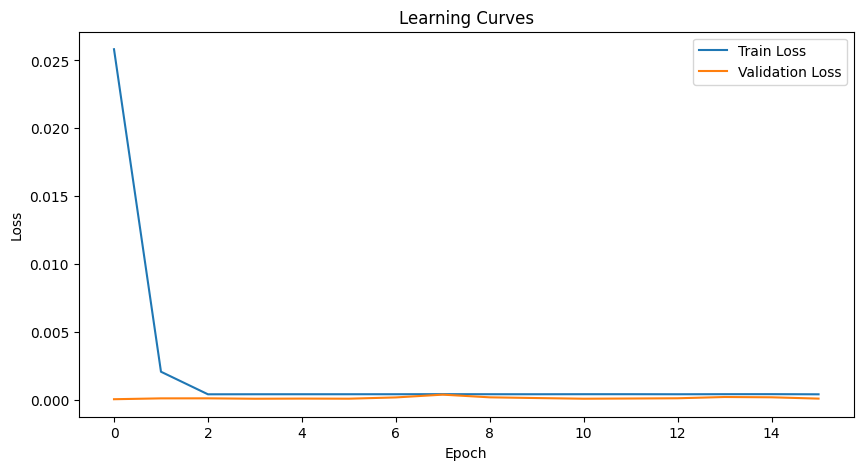

In [5]:
def create_sequences(data, target, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(target.iloc[i + seq_length])
    return np.array(sequences), np.array(targets)

def main():
    file_path = "EURUSD_Candlestick_1_Hour_BID_01.01.2004-30.03.2024.csv"
    X_train, X_val, y_train, y_val, scaler = load_and_preprocess_data(file_path)

    sequence_length = 24

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)

    X_train_tensor = torch.Tensor(X_train_seq)
    X_val_tensor = torch.Tensor(X_val_seq)
    y_train_tensor = torch.Tensor(y_train_seq).unsqueeze(1)
    y_val_tensor = torch.Tensor(y_val_seq).unsqueeze(1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_size = X_train_tensor.shape[2]
    output_size = 1
    model = GRUTFTModel(input_size, output_size)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

    epochs = 50
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience, trials = 15, 2

    for epoch in range(epochs):
        model.train()
        epoch_train_losses = []

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        train_losses.append(np.mean(epoch_train_losses))

        model.eval()
        with torch.no_grad():
            val_loss = np.mean([criterion(model(X_batch), y_batch).item() for X_batch, y_batch in val_loader])
            val_losses.append(val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                trials = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                trials += 1
                if trials >= patience:
                    print("Early stopping triggered")
                    break

    plot_learning_curves(train_losses, val_losses)

if __name__ == "__main__":
    main()


## Visualization
Generating visuals and plottings to visualize model's training performance.

Validation Loss: 5.2161511121084914e-05
Mean Squared Error: 5.2161511121084914e-05
Mean Absolute Error: 0.005920484196394682
R^2 Score: 0.98666912317276


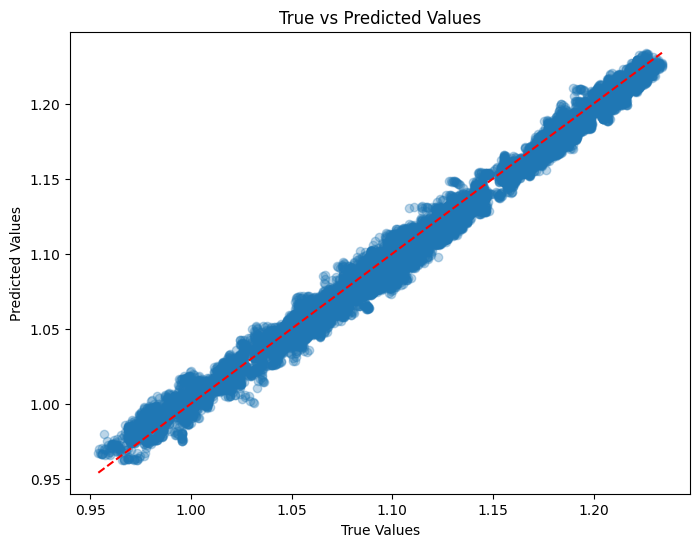

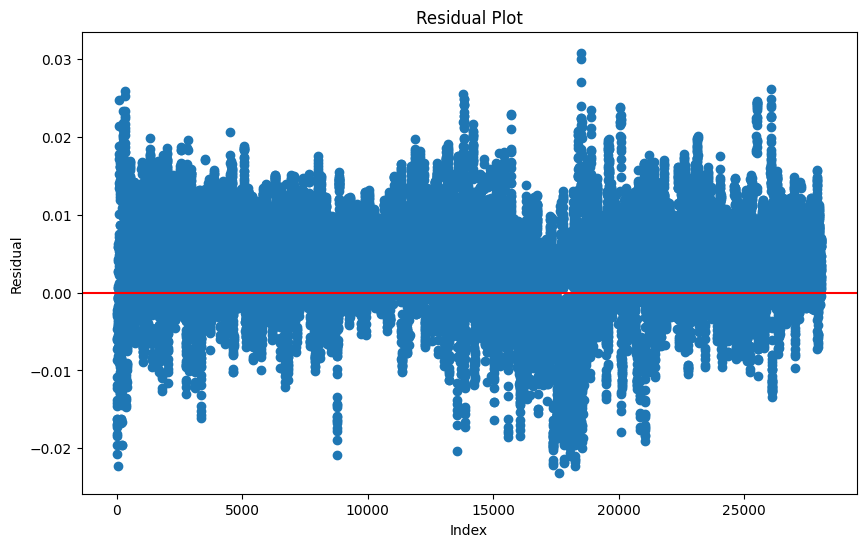

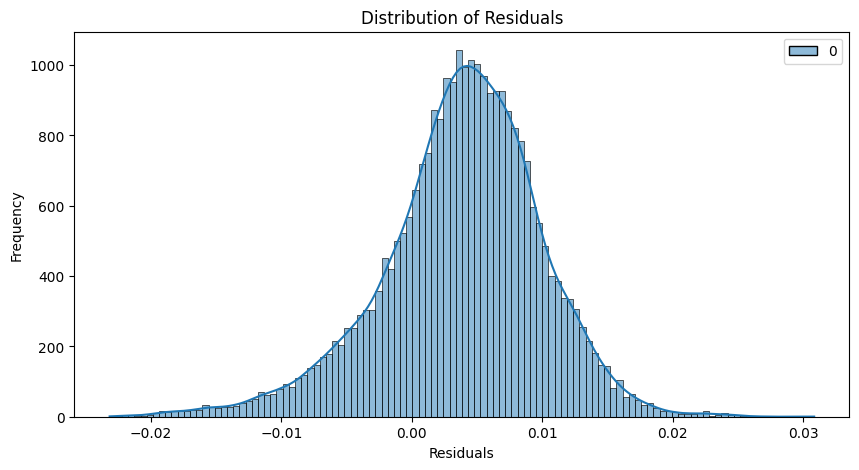

In [6]:
def eval():
    file_path = "EURUSD_Candlestick_1_Hour_BID_01.01.2004-30.03.2024.csv"
    X_train, X_val, y_train, y_val, scaler = load_and_preprocess_data(file_path)

    sequence_length = 24

    X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)

    X_val_tensor = torch.Tensor(X_val_seq)
    y_val_tensor = torch.Tensor(y_val_seq).unsqueeze(1)

    input_size = X_val_tensor.shape[2]
    output_size = 1
    model = GRUTFTModel(input_size, output_size)

    model.load_state_dict(torch.load('best_model.pth'))

    criterion = nn.MSELoss()

    evaluate_model(model, criterion, X_val_tensor, y_val_tensor)

if __name__ == "__main__":
    eval()
